In [192]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

dfTest      = pd.read_csv('C:/Users/User/Downloads/car_breakdown_prediction-develop/data/car_breakdown_test.tsv', sep='\t')
dfTestTruth = pd.read_csv('C:/Users/User/Downloads/car_breakdown_prediction-develop/data/car_breakdown_test_truth.tsv', sep='\t')
dfTrain     = pd.read_csv('C:/Users/User/Downloads/car_breakdown_prediction-develop/data/car_breakdown_train.tsv', sep='\t')

In [18]:
# len(dfTest)
# len(dfTestTruth)
# len(dfTrain)

## Assumpitons 
1. All **100 vehicles** are assumed to be different and has been treated in a individual manner.

## Different approaches which can be used for predicting breakdown
Out of 21 sensors if we find rolling mean/mean or plot the sensor data, only s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
are observed to change with the day while others are either constant or have mininmal deviation.

  **Method 1 :** Out of filtered sensors there is either a dip in values or a lift in values, a rolling mean would of 2-4 days would
  serve the purpose, for each sensors ~30 days proir the trends starts changing, we can mark the thresholdd values over which the
  flag would be raised for each sensor and if majority of the sensors shows the threshold breach we can have a breakdown indicator.
  
  **Method 2 :** There could be a more robust way for this, what we have tried is fitting an ensemble based boosting algorithm 
  which can give slightly extra confidence and would also tell the probaility of the failure prediction. I have treated all the
  vehicles differently. A **target variable is defined** in a manner where for each vehicle, corresponding to the day, either 0 or 1 
  has been marked. Say for example a vehicle lasts 150 days, till 120 days the target variable is 0 and post that its 1, this 
  number couls have been chamnged (but the requirement was to predict failure around 30 days). Instead of predicting 0 and 1 
  we have predicted the probabilty of day's sensor data pattern bieng close to 0 or 1, which would give a better picture of whatever
  we are predicting.
  
  If we assume ground data to be true (which is not satisfactorily true, as even after plotting the raw sensors data over days, in
  many cases no trends are observed which points towards the breakdown as observed in train data), about 25 vehicles out of 100 had
  RUL around 30, and out of 25 vehicles the model could predict the failure for 20 vehicles with over 0.50 probability, and also 22
  vehicles out of 25 at some point showed trend towards breakdown but didnt fail eventually. 
  
  So precision was observed to be ~80%, assuming the ground data is true. False positives was an focused more, as that would impact
  business a lot, telling a vehicle wuld fail and blockig it for maintainace would decrease the revenue from thta car.
  
  **dfAccuTrain** : Contains accuracy observed obe training 100 models over 100 cars.   
  **dfAccuTestl** : Contains accuracy over test data with probability threshold of 0.50 and higher, after looking 
                    at the end days of data
  **dfInd**       : contains flag if at any point of time over all the days of test data, if any patterns similar to the breakdown
                    vehicle data was observed (36 vehicle showed flag,  28 to be dominant flags and 8 as minor flags)
                    
  **Method 3** : We can calculate **feature importance scores** based on the sensors and figure out the importance order of the
  sensors and assosiate the proportional scores to the sensors, to predict the breakdown of a vehicle.
  
  **Method 3** : Simple classification model (k-means should work for this king of data) can also be used, **good thing is manual 
  marking will not be required** for this, we can assume 3 clusters, 1 for a healthy vehicle pattern, other for degrading vehicle
  and the 3rd one fot the last stage of breaking down vehicle.
  
  **Method 4**: If we had large amount of data nueral metwork classifiers could also be used, which could have yielded a higher
  acuracy.
  
  **Method 5 :** A more complex but yet quite reliable would be using HMM's, it would be usefull for this king of data as its a time
  series data, and hidden staes could be marked as 3 which is good health, average health and bad health, just that sample points to
  train are less than ideal to start with.

In [39]:
# dfTest[dfTest.vehicleId==3]
# dfTest.vehicleId.value_counts()
# dfTrain.columns

In [21]:
# dfTestTruth.columns

In [27]:
# dfTestTruth.vehicleId.nunique()

In [34]:
# dfTest[dfTest.vehicleId==1]

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

In [276]:
# dfTestTruth['lengthOfData']=
# dfTest['counter']=1
dfTestTruth['counter']=dfTest.groupby('vehicleId').count()['days'].values
# dfTestTruth.tail()

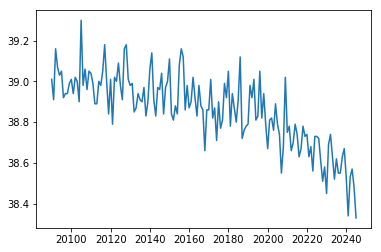

In [473]:
plt.plot(dfTrain.s20[dfTrain.vehicleId==98])
# plt.plot(dfTest.s20[dfTest.vehicleId==98])

In [ ]:
s2,s3,s4,s7,s8, s9 ,s11,s12,s13, s14 ,s15,s17,s20,s21

In [144]:
# dfTrain.groupby('vehicleId')['s2','s3','s4','s7','s8','s11','s12','s13','s15','s17','s20','s21'].mean()
# dfTrain.groupby('vehicleId')['s2','s3','s4','s7','s8','s11','s12','s13','s15','s17','s20','s21'].std()

In [152]:
# dfTrain['s2ma'] = dfTrain['s2'].rolling(5).mean()
# plt.plot(dfTrain.s2[dfTrain.vehicleId==1])

In [449]:
accu=[]
testDayf=[]
testDayl=[]
testOverall=[]
for j in range(1,101,1):
    dfTemp = dfTrain[dfTrain.vehicleId==j]
    dfTemp = dfTemp.reset_index()
    a = len(dfTemp)
    target=[]
    for k in range(0,a,1):
        if(dfTemp.days[k]<(a-30)):
            x=0
    #         x=100
        else:
            x=1
    #         x=100-3.37*(k-(a-30))
        target.append(x)
    dfTemp['target']=target  
    import numpy as np
    from sklearn.model_selection import train_test_split
    trainFeatures = ['s2','s3','s4','s7','s8','s11','s12','s13','s15','s17','s20','s21']

    import xgboost as xgb
    xDf = dfTemp.filter(trainFeatures,axis=1)
    yDf = dfTemp.filter(['target'])

    X = xDf.filter(trainFeatures,axis=1).values
    Y = yDf.values

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=210)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest  = xgb.DMatrix(X_test,  label=y_test)

    param = {
        'max_depth': 5,  # the maximum depth of each tree
        'eta': 0.1,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'objective' : 'multi:softprob',
         'num_class' : 2,
        'colsample_bytree': 1,
        'subsample':1}  # the number of classes that exist in this datset
    num_round =400  # the number of training iterations
    model = xgb.train(param, dtrain, num_round)

    from sklearn.metrics import confusion_matrix
    pred = model.predict(dtest)
    bestPred = np.asarray([np.argmax(line) for line in pred])
    # df_confusion = confusion_matrix(bestPred,y_test)
    # dfConfusion = pd.DataFrame(df_confusion)
    # dfConfusion

    dftest = pd.DataFrame(X_test,columns=trainFeatures)
    # dftest = X_test
    dftest['actual']= y_test
    dftest['catg0'] = pred[:,0]
    dftest['catg1'] = pred[:,1]
    dftest['best'] = bestPred
    dftest['count'] = 1
    p=[]
    for l in range(0,len(dftest),1):
        if(dftest['catg1'][l]>0.70):
    #         print(dftest.catg0[l])
            w=1
        else:
            w=0
        p.append(w)

    dftest['pbVal>0.70']=p
    df_confusion = confusion_matrix(dftest['pbVal>0.70'],dftest['actual'])
#     dfConfusion = pd.DataFrame(df_confusion)
#     dfConfusion
#     falseNegitives = df_confusion[0,1]*100/(df_confusion[0,0]+df_confusion[0,1])
#     falsePositives = df_confusion[1,0]*100/(df_confusion[0,0]+df_confusion[1,0])
    recall = df_confusion[1,0]*100/(df_confusion[1,0]+df_confusion[0,0])
    precision = df_confusion[1,1]*100/(df_confusion[0,1]+df_confusion[1,1])
    accuracy = [j,precision,recall]
    accu.append(accuracy)
#----------------------------------------------------------------------------------------------------------------------------------    
    dfTempTest = dfTest[dfTest.vehicleId==j]
    
    dff = dfTempTest.drop_duplicates(subset='vehicleId',keep='first')
    xDff = dff.filter(trainFeatures,axis=1)
    xValf = xDff.values
    Xf = xValf
    dtf = xgb.DMatrix(Xf)
    
    dfl = dfTempTest.drop_duplicates(subset='vehicleId',keep='last')
    xDfl = dfl.filter(trainFeatures,axis=1)
    xVall = xDfl.values
    Xl = xVall
    dtl = xgb.DMatrix(Xl)
    
    predTestf  = model.predict(dtf)
    predTestl  = model.predict(dtl)
    
    bestPredTestf = np.asarray([np.argmax(line) for line in predTestf])
    testPredictionf = [j,predTestf[:,1],bestPredTestf]
    
    bestPredTestl = np.asarray([np.argmax(line) for line in predTestl])
    testPredictionl = [j,predTestl[:,1],bestPredTestl]
    
    testDayf.append(testPredictionf)
    testDayl.append(testPredictionl)
    
    xDfO = dfTempTest.filter(trainFeatures,axis=1)
    xValO = xDfO.values
    XO = xValO
    dtO = xgb.DMatrix(XO)
    predTestO  = model.predict(dtO)
    bestPredTestO = np.asarray([np.argmax(line) for line in predTestO])
    ans = check_availability(1, bestPredTestO)
    overallPred = [j,ans]
    testOverall.append(overallPred)
    
#--------------------------------------------------------------------------------------------------------------------------------
    
dfAccuTrain  = pd.DataFrame(accu,columns=['vehicleId','precision','recall'])
dfAccuTestf  = pd.DataFrame(testDayf,columns=['vehicleId','breakdownProbf','bestPredTestf'])
dfAccuTestl  = pd.DataFrame(testDayl,columns=['vehicleId','breakdownProbl','bestPredTestl'])
dfInd        = pd.DataFrame(testOverall,columns=['vehicleId','breakdownFlag'])

In [456]:
l3=dfInd.vehicleId[dfInd.breakdownFlag==True].values

In [387]:
# dfAccuTest.head()
# dfAccuTestf[dfAccuTestf.bestPredTestf==1]
# dfAccuTestl.head()

In [405]:
# dfAccuTestf['breakdownProbf'] = dfAccuTestf['breakdownProbf'].str.get(0)
# dfAccuTestf['bestPredTestf']  = dfAccuTestf['bestPredTestf'].str.get(0)

# dfAccuTestl['breakdownProbl'] = dfAccuTestl['breakdownProbl'].str.get(0)
# dfAccuTestl['bestPredTestl']  = dfAccuTestl['bestPredTestl'].str.get(0)

In [479]:
l2 =dfAccuTestl.vehicleId[dfAccuTestl.bestPredTestl==1].values
# plt.hist(dfAccuTestl.breakdownProbl)

In [420]:
# dfTestTruth['30diff'] = dfTestTruth.RUL-dfTestTruth.counter
# dfTestTruth.head()

In [480]:
# plt.hist(dfTestTruth.RUL)
l1 = dfTestTruth.vehicleId[dfTestTruth.RUL<30].values
# dfTestTruth.vehicleId[(dfTestTruth['30diff']>25) & (dfTestTruth['30diff']<35)].values

In [481]:
common = [i for i in l1 if i in l2]

In [482]:
len(common)

20

In [460]:
def check_availability(element, collection: iter):
    return element in collection

In [483]:
precision = len(common)*100/len(l1)
precision

80.0